<a href="https://colab.research.google.com/github/emilyvainberg12/ECE-188/blob/main/Emily_V_Task2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Perform an Adversarial attack.

For the second part of the project we consider a trained model (MobileNet) which is trained on the imagenet dataset. 

We use an evasion attack called [FGSM](https://neptune.ai/blog/adversarial-attacks-on-neural-networks-exploring-the-fast-gradient-sign-method#:~:text=The%20Fast%20Gradient%20Sign%20Method%20(FGSM)%20combines%20a%20white%20box,model%20into%20making%20wrong%20predictions.) to fool the neural network into making incorrect predictions.

## Import Packages.

Import the necessary packages we continue to use Tensorflow and Keras

In [1]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
from keras.preprocessing import image

mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False

## Load the Pretrained model. 

We use the [MobileNetV2](https://arxiv.org/abs/1801.04381) model trained on the [Imagenet](https://www.image-net.org/) dataset. 

In [23]:
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True,
                                                     weights='imagenet')
pretrained_model.trainable = False

# ImageNet labels
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

### Helper Function for Data Processing


Following functions can be used for data processing. Dont worry about these, just use them. 

In [24]:
# Helper function to preprocess the image so that it can be inputted in MobileNetV2
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224))
  image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
  image = image[None, ...]
  return image

# Helper function to extract labels from probability vector
def get_imagenet_label(probs):
  return decode_predictions(probs, top=1)[0][0]

## Load an Image. 


Load any image, we consider an image of a Golden Retriever. 

In [4]:
image_raw = tf.io.read_file('/content/panda_bear.jpeg')
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

49152/35363 [=========================================] - 0s 0us/step


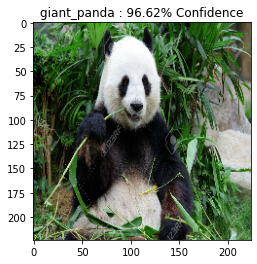

In [5]:
plt.figure()
plt.imshow(image[0] * 0.5 + 0.5)  # To change [-1, 1] to [0,1]
_, image_class, class_confidence = get_imagenet_label(image_probs)
plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
plt.show()

## Create the Adversarial Image. 

We use the FGSM method to create an adversarial image. Be sure to read about FGSM to understand how the attack works. 

In [6]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = pretrained_model(input_image)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

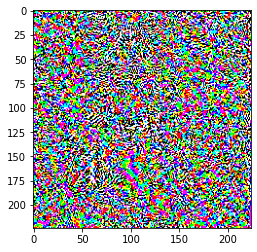

In [7]:
# Get the input label of the image.
giant_panda_index = 388
label = tf.one_hot(giant_panda_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]

In [8]:
def display_images(image, description):
  _, label, confidence = get_imagenet_label(pretrained_model.predict(image))
  plt.figure()
  plt.imshow(image[0]*0.5+0.5)
  plt.title('{} \n {} : {:.2f}% Confidence'.format(description,
                                                   label, confidence*100))
  plt.show()

In [ ]:
epsilons = [0, 0.01, 0.1, 0.15]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)
  display_images(adv_x, descriptions[i])

# Task2: Perform an Analysis to understand the potency of the attack. 

Your task here is to understand how small a change could change the class output and this is measured by the epsilon value needed to change the class. 

Your task is as follows:

* Pick 10 images each from different classes in imagenet. 
* Perform a perturbation analysis on each of these images. 
* In the analysis you are required to report the smallest epsilon value for which you notice a class change. 
* Make a table for each of the images considered with the minimum epsilon value for the FGSM attack. 

Write the Code for the above below. You can add the table also below. 

In [47]:
#function to run code
def run_code(image_raw, index):
  image = tf.image.decode_image(image_raw)
  image = preprocess(image)
  image_probs = pretrained_model.predict(image)
  _, image_class, class_confidence = get_imagenet_label(image_probs)

  index = index
  label = tf.one_hot(index, image_probs.shape[-1])
  label = tf.reshape(label, (1, image_probs.shape[-1]))

  perturbations = create_adversarial_pattern(image, label)

  epsilons = [0, 0.0001, 0.001, 0.0015, 0.002, 0.0025, 0.003, 0.004, 0.005, 0.01, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5]
  descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input') for eps in epsilons]

  original_class = image_class;

  for i, eps in enumerate(epsilons):
    adv_x = image + eps*perturbations
    adv_x = tf.clip_by_value(adv_x, -1, 1)
    _, label, confidence = get_imagenet_label(pretrained_model.predict(adv_x))
    if original_class != label:
      display_images(adv_x, descriptions[i])
      break


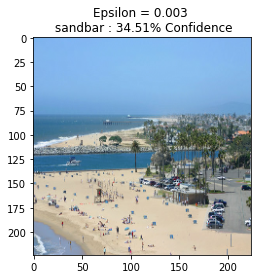

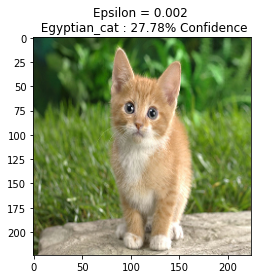

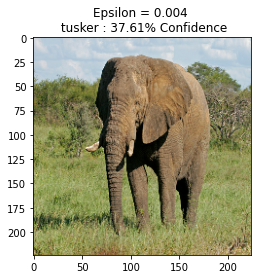

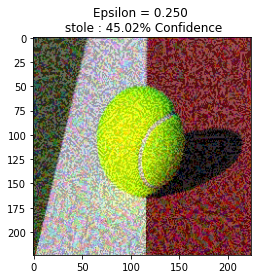

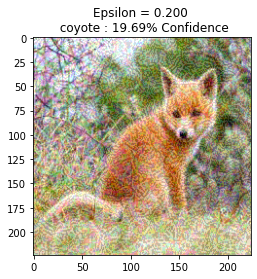

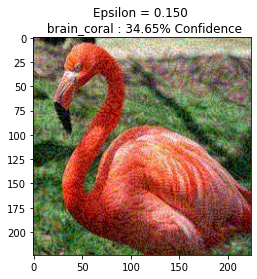

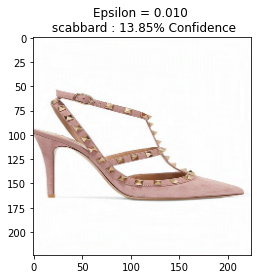

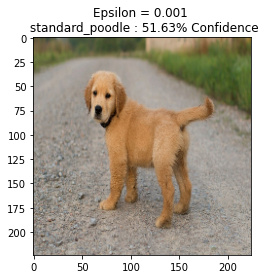

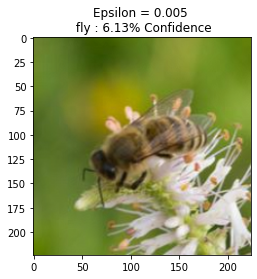

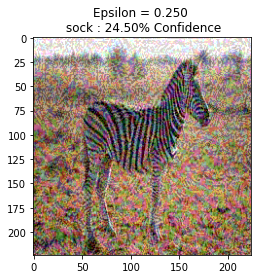

In [48]:
#add 10 images and run function for them to deterime epsilon that causes class change
images = {
    'beach' : 978,
    'cat' : 281,
    'elephant' : 386,
    'tennis' : 852,
    'fox': 277,
    'flamingo' : 130,
    'heels' : 774,
    'dog': 207,
    'bee': 309,
    'zebra': 340
    
}

for name, index_num in images.items(): 
  filename = ('/content/'+name+'.jpeg')
  image = tf.io.read_file(filename)
  run_code(image, index_num)

**TABLE FOR PERTUBATION OF 10 IMAGES:**

| Actual Class | Class Change | Epsilon Value |
| :- | -: | :-: |
| seashore | sandbar | 0.003
| tabby  | egyptian cat | 0.002
| african elephant | tusker | 0.004
| tennis ball | stole | 0.25
| red fox | coyote | 0.200
| flamingo | brain coral | 0.150
| sandal | scabbard | 0.01
| golden retriver | standard poodle | 0.001
| bee | fly | 0.005
| zebra | sock | 0.25

# Task3: Compare the robustness of the considered model with other models. 

Your task here is to compare how this model (MobileNetV2) compares with other popular object detection models. 

Your task is as follows:

* Consider 5 different models (you can consider various RESNET architectures, any models you find interesting).
* Load the pre-trained weights of the model (trained on imagenet). 
* Perform Task2 on all the considered models. 
* Add all the results in the table. Hence the final table you have 6 columns for each model and epsilon values for each of the 10 images for all 6 models. 


What do you observe? Why do you think this is the case? 

Write the Code for the above below. You can also add the table and answer to the question below. 


In [52]:

index = [978, 281, 386, 852, 277, 130, 774, 207, 309, 340]

# choose 5 different models 
# link to page explain models: https://www.tensorflow.org/api_docs/python/tf/keras/applications
pretrained_models = [tf.keras.applications.MobileNetV2(include_top=True, weights='imagenet'),
                     tf.keras.applications.DenseNet121(include_top=True, weights='imagenet'),
                     tf.keras.applications.ResNet101(include_top=True, weights='imagenet'),
                     tf.keras.applications.NASNetMobile(include_top=True, weights='imagenet'),
                     tf.keras.applications.EfficientNetB0(include_top=True, weights='imagenet')]
for x in pretrained_models:
  x.trainable = False

for name, index in images.items(): 
  filename = ('/content/'+name+'.jpeg')
  image_raw = tf.io.read_file(filename)
  image_dec = tf.image.decode_image(image_raw)

  for model in pretrained_models:
    image = preprocess(image_dec)
    image_probs = model.predict(image)
    label = name

    # create pertubation 
    classname = tf.one_hot(index, image_probs.shape[-1])
    classname = tf.reshape(classname, (1, image_probs.shape[-1]))

    perturbations = create_adversarial_pattern(image, classname)

    eps = 0
    while(label == name):
     # add perturbation with epsilon
      adv_x = image + eps*perturbations
      adv_x = tf.clip_by_value(adv_x, -1, 1)
      _, label, confidence = get_imagenet_label(model.predict(adv_x))
      eps += 0.01

    # uncomment to check correct values
    # print(name)
    # print(eps)



**TABLE FOR PERTUBATION OF 10 IMAGES:**

| Image | Mobile V2 | DenseNet 121 | Resnet 101 | EfficientNet B0 |  NASANet  |
| :- | -: | :-: | -: | -: | -: |
| seashore | 0.01 | 0.01 | 0.01 |0.01 | 0.01| 0.01
| tabby | 0.01 | 0.01 | 0.01 |0.01 | 0.01| 0.01
| african elephant | 0.01 | 0.01 | 0.01 |0.01 | 0.01| 0.01
| tennis ball | 0.01 | 0.01 | 0.01 |0.01 | 0.01| 0.01
| red fox | 0.01 | 0.01 | 0.01 |0.01 | 0.01| 0.01
| flamingo | 0.012 | 0.44 | 0.01 |0.01 | 0.37 | 0.01
| sandal | 0.01 | 0.01 | 0.01 |0.01 | 0.01| 0.01
| golden retriver | 0.01 | 0.01 | 0.01 |0.01 | 0.01| 0.01
| bee | 0.02 | 0.06 | 0.01 |0.01 | 0.1| 0.01
| zebra | 0.24 | 0.46 | 0.01 |0.01 | 0.36 | 0.01

# BONUS: Can you provide a better attack?

Can you design a better attack that lowers the epsilon required for the images?

Task:

* Design another attack. 
* Compare the epsilon values on 10 images. 
* Does it perform better than the FGSM attack? That is, does it have lower epsilon values?

Write the code and provide your answers below. 